# Random Forest with Gabor and Sobel Filters - Extraction Classification of     Flooding and Regular State

##### In this notebook the implementation of random forest model for the classification on extraction column images to their respective flooding or regular states have been done. 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel

In [2]:
print(os.listdir("C:/Users/training/"))

['Flooding', 'Regular_State']


#### Click here for more information

## 1. Preprocessing images and converting them into numpy arrays for Training&Testing

In [ ]:
#Capture images and labels into arrays.
#Start by creating empty lists.
train_images = []
train_labels = [] 
for directory_path in glob.glob("C:/Users/training/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #Reading grayscale images
        img = cv2.resize(img, (64, 64))#Resize images
        train_images.append(img)
        train_labels.append(label)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
#Do exactly the same for test images
# test
test_images = []
test_labels = [] 
for directory_path in glob.glob("C:/Users/testing/*"):
    column_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64,64))
        test_images.append(img)
        test_labels.append(column_label)

In [6]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
#Encode labels from text (folder names) to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
#If you only have one dataset then split here
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

## 2. Function for Feature Extraction from the given Dataset

In [ ]:
#FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, :,:]
        img = input_img
            #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
         # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        #df['Image_Name'] = image   #Capture image name as we read multiple images
        
        # FEATURE 2 - Bunch of Gabor filter responses
        
                #Generate Gabor features
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            sigma = 1  #Sigma with 1
            lamda = np.pi/4
            gamma = 0.5
            gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.

            ksize=9
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
            kernels.append(kernel)
            #Now filter the image and add values to a new column 
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
            #print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
            num += 1  #Increment for gabor column label
                
         
            # FEATURE 3 Sobel
            edge_sobel = sobel(img)
            edge_sobel1 = edge_sobel.reshape(-1)
            df['Sobel'] = edge_sobel1
       
        #Add more filters as needed
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

## 3. Definition of Random Forest Classifier and GridSearchCV for the n_estimator Parameter Selection 

In [ ]:
grid_search.best_params_

## 4. Fitting Model Parameters and Prediction of Model with the Test Dataset 

In [ ]:
RF_model = RandomForestClassifier(n_estimators= 50 , random_state =42)

# Fit the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

#Predict on test
test_prediction = RF_model.predict(test_for_RF)
#Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)

## 5. Model Analysis via Confusion Matrix / Precision, Recall

In [12]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_prediction))

Accuracy =  0.993514915693904


               precision    recall  f1-score   support

     Flooding       0.99      1.00      0.99       801
Regular_State       1.00      0.99      0.99       741

     accuracy                           0.99      1542
    macro avg       0.99      0.99      0.99      1542
 weighted avg       0.99      0.99      0.99      1542



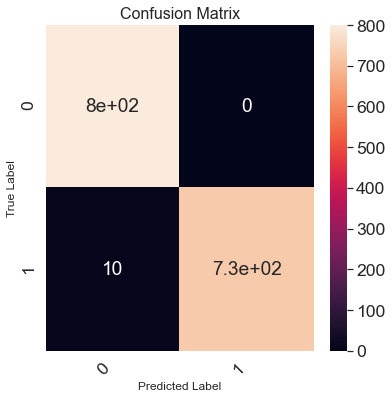

In [32]:
#Print confusion matrix
target_names = ['Flooding', 'Regular_State']
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_labels, test_prediction)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
print(classification_report(test_labels, test_prediction, target_names=target_names))

## 6. Evaluation of the Random Forest Model for a Random Image

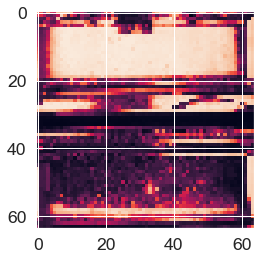

In [33]:
#Check results on a few random images
import random
n=random.randint(0, x_test.shape[0]-1) #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
#plt.title('Extraction Column in dimensions of 64x64')
plt.show()

In [15]:
#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = RF_model.predict(input_img_for_RF)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", test_labels[n])

The prediction for this image is:  ['Regular_State']
The actual label for this image is:  Regular_State


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
